In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the csv into dataframes
companies=pd.read_csv('companies.txt',sep='\t',encoding = "ISO-8859-1")
rounds2=pd.read_csv('rounds2.csv',encoding = "ISO-8859-1")

# create new column in both the dataframe in lower case so that i can merge using it.
companies['permalink']=companies['permalink'].str.lower()
rounds2['company_permalink'] = rounds2['company_permalink'].str.lower()

# Print the uniq entries of companies present in the both the data frames
print ("Uniq entries of companies in rounds2 :",len(rounds2['company_permalink'].unique()))
print ("Uniq entries of companies in companies:",len(companies['permalink'].unique()))


## Merge rounds2 and companies data frame
master_frame=pd.merge(rounds2,companies,how="left", left_on='company_permalink', right_on='permalink')
# Total no of observations in master_frame
master_frame.shape

# To avoid scientific representation
pd.set_option('display.float_format', lambda x: '%.3f' % x)


# Data Cleaning

Uniq entries of companies in rounds2 : 66370
Uniq entries of companies in companies: 66368


In [118]:
# We will calculate total amount raised so that we can calculate the fraction of the investment
total_investments=pd.DataFrame(master_frame,columns=['raised_amount_usd'])
sum_of_total_investment=total_investments.sum(axis=0)
print('sum_of_total_investment :',sum_of_total_investment)
master_frame['Total_investment_raised_usd']=(990125085135.000/1000000)
print (master_frame.funding_round_type.unique())
master_frame.isnull().sum()


sum_of_total_investment : raised_amount_usd   990125085135.000
dtype: float64
['venture' 'seed' 'undisclosed' 'equity_crowdfunding' 'convertible_note'
 'private_equity' 'debt_financing' 'angel' 'grant' 'secondary_market'
 'post_ipo_equity' 'post_ipo_debt' 'product_crowdfunding'
 'non_equity_assistance']


company_permalink                  0
funding_round_permalink            0
funding_round_type                 0
funding_round_code             83809
funded_at                          0
raised_amount_usd              19990
permalink                         74
name                              75
homepage_url                    6200
category_list                   3461
status                            74
country_code                    8711
state_code                     10977
region                         10200
city                           10197
founded_at                     20562
Total_investment_raised_usd        0
dtype: int64

In [119]:
# Total no of observations
len(master_frame.index)


114949

In [120]:
# Calculate the percentage of null values in each column
round(100*(master_frame.isnull().sum())/len(master_frame.index),2)

company_permalink              0.000
funding_round_permalink        0.000
funding_round_type             0.000
funding_round_code            72.910
funded_at                      0.000
raised_amount_usd             17.390
permalink                      0.060
name                           0.070
homepage_url                   5.390
category_list                  3.010
status                         0.060
country_code                   7.580
state_code                     9.550
region                         8.870
city                           8.870
founded_at                    17.890
Total_investment_raised_usd    0.000
dtype: float64

In [121]:
# Removed the rows where raised_amount_usd is null
master_frame=master_frame[~master_frame.raised_amount_usd.isnull()]

In [122]:
# After removing the null values
len(master_frame.index)

94959

In [123]:
round(100*(master_frame.isnull().sum())/len(master_frame.index),2)

company_permalink              0.000
funding_round_permalink        0.000
funding_round_type             0.000
funding_round_code            70.340
funded_at                      0.000
raised_amount_usd              0.000
permalink                      0.050
name                           0.050
homepage_url                   4.610
category_list                  1.140
status                         0.050
country_code                   6.190
state_code                     8.030
region                         7.450
city                           7.440
founded_at                    16.840
Total_investment_raised_usd    0.000
dtype: float64

Now will removing some more columns which is not useful for our analysis like city,founded_at,region,state_code,homepage_url

In [124]:
master_frame.drop(columns=['city','funded_at','founded_at','funding_round_permalink','region','state_code','homepage_url','funding_round_code','status'],axis=1,inplace=True)

Removing the null rows ( category_list and country_code ) from the master frame

In [125]:
master_frame=master_frame[(~master_frame.category_list.isnull()) & (~master_frame.country_code.isnull())]

Checking the data quality one last time

In [126]:
round(100*(master_frame.isnull().sum())/len(master_frame.index),2)

company_permalink             0.000
funding_round_type            0.000
raised_amount_usd             0.000
permalink                     0.000
name                          0.000
category_list                 0.000
country_code                  0.000
Total_investment_raised_usd   0.000
dtype: float64

In [127]:
# Total types of investment present
len(master_frame.funding_round_type.unique())

14

Now lets focus on investment type analysis. 

As Spark Funds wants to choose one of these four investment types such as seed,venture,angel,private_equity so lets work on the data related to those categories only

In [91]:
master_frame = master_frame[master_frame['funding_round_type'].isin (['seed','venture','angel','private_equity'])]

In [92]:
# Converting $ to million $
master_frame['raised_amount_usd']=master_frame['raised_amount_usd'].apply(lambda x : x/1000000)

In [93]:
# Avg amount invested in the choosen sectors
print ("Avg amount invested in each sector \n" ,master_frame.groupby('funding_round_type')['raised_amount_usd'].mean().sort_values(ascending=False))
print ("Sum of total amount invested in each sector \n", master_frame.groupby('funding_round_type')['raised_amount_usd'].sum().sort_values(ascending=False))
# Create additional column fraction of investment
master_frame['Fraction_of_investment']=master_frame['raised_amount_usd']/master_frame['Total_investment_raised_usd']
print(master_frame.groupby('funding_round_type')['Fraction_of_investment'].sum().sort_values(ascending=False))


Avg amount invested in each sector 
 funding_round_type
private_equity   73.938
venture          11.724
angel             0.972
seed              0.748
Name: raised_amount_usd, dtype: float64
Sum of total amount invested in each sector 
 funding_round_type
venture          560523.363
private_equity   134568.045
seed              15774.151
angel              4274.925
Name: raised_amount_usd, dtype: float64
funding_round_type
venture          0.566
private_equity   0.136
seed             0.016
angel            0.004
Name: Fraction_of_investment, dtype: float64


Hence the clear winner is venture ( 5 million - 15 million ) type of investment. So we move on to country wise analysis

In [94]:
investment_df=master_frame[master_frame['funding_round_type'] == 'venture']

In [95]:
investment_df.isnull().sum()

company_permalink              0
funding_round_type             0
raised_amount_usd              0
permalink                      0
name                           0
category_list                  0
country_code                   0
Total_investment_raised_usd    0
Fraction_of_investment         0
dtype: int64

Top nine countries which have received the highest total funding for the investment type "venture"

In [96]:
investment_df.groupby('country_code')['raised_amount_usd'].sum().sort_values(ascending=False).head(9)

country_code
USA   420068.029
CHN    39338.919
GBR    20072.813
IND    14261.509
CAN     9482.218
FRA     7226.851
ISR     6854.350
DEU     6306.922
JPN     3167.647
Name: raised_amount_usd, dtype: float64

Creating a data frame named top9 with the top nine countries

In [97]:
top9 = investment_df[investment_df['country_code'].isin(["USA","CHN","GBR","IND","CAN","FRA","ISR","DEU","JPN"])]


Sector Analysis : 

For some companies, the category list is a list of multiple sub-sectors separated by a pipe (vertical bar |). For example, one of the companies’ category_list is Application Platforms|Real Time|Social Network Media.
So the business rule that the first string before the vertical bar will be considered the primary sector. In the example above, ‘Application Platforms’ will be considered the primary sector.

We will create another column in top9 dataframe called primary_sector deriving values from category_list.

In [98]:
# Apply a function to create the primary sector column from the category-list column
top9['primary_sector']=top9['category_list'].apply(lambda x : x.split('|')[0])

C:\Users\vbasavar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [99]:
top9[(top9['country_code']=="USA" ) & (top9['raised_amount_usd'] >= 5 )].head()


,company_permalink,funding_round_type,raised_amount_usd,permalink,name,category_list,country_code,Total_investment_raised_usd,Fraction_of_investment,primary_sector
10,/organization/0xdata,venture,20.000,/organization/0xdata,H2O.ai,Analytics,USA,990125.085,0.000,Analytics
12,/organization/0xdata,venture,8.900,/organization/0xdata,H2O.ai,Analytics,USA,990125.085,0.000,Analytics
22,/organization/1-mainstream,venture,5.000,/organization/1-mainstream,1 Mainstream,Apps|Cable|Distribution|Software,USA,990125.085,0.000,Apps
62,/organization/1010data,venture,35.000,/organization/1010data,1010data,Software,USA,990125.085,0.000,Software
73,/organization/10x-genomics,venture,55.000,/organization/10x-genomics,10X Genomics,Biotechnology|Technology,USA,990125.085,0.000,Biotechnology


In [100]:
mapping = pd.read_csv('mapping.csv',encoding = "ISO-8859-1")
mapping.head()

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
0,NaN,0,1,0,0,0,0,0,0,0
1,3D,0,0,0,0,0,1,0,0,0
2,3D Printing,0,0,0,0,0,1,0,0,0
3,3D Technology,0,0,0,0,0,1,0,0,0
4,Accounting,0,0,0,0,0,0,0,0,1


In [101]:
mapping = pd.melt(mapping,id_vars=['category_list'])

In [102]:
mapping.category_list.unique()

array([nan, '3D', '3D Printing', '3D Technology', 'Accounting',
       'Active Lifestyle', 'Ad Targeting', 'Advanced Materials',
       'Adventure Travel', 'Advertising', 'Advertising Exchanges',
       'Advertising Networks', 'Advertising Platforms', 'Advice',
       'Aerospace', 'Agriculture', 'Air Pollution Control', 'Algorithms',
       'All Markets', 'All Students', 'Alter0tive Medicine', 'Alumni',
       'A0lytics', 'Android', 'Angels', 'Animal Feed',
       'Anything Capital Intensive', 'App Discovery', 'App Marketing',
       'App Stores', 'Application Performance Monitoring',
       'Application Platforms', 'Apps', 'Aquaculture', 'Architecture',
       'Archiving', 'Art', 'Artificial Intelligence', 'Artists Globally',
       'Assisitive Technology', 'Assisted Living', 'Auctions', 'Audio',
       'Audiobooks', 'Augmented Reality', 'Auto', 'Automated Kiosk',
       'Automotive', 'B2B', 'B2B Express Delivery', 'Babies',
       'Baby Accessories', 'Baby Boomers', 'Baby Safety', 'B

In the above output observed that there are some spell mistakes where Analytics is wrongly mentioned as A0lytics and to correct that replace function is applied

In [103]:
mapping.category_list = mapping.category_list.replace({'0':'na', '2.na' :'2.0'}, regex=True)


In [104]:
mapping.category_list.unique()

array([nan, '3D', '3D Printing', '3D Technology', 'Accounting',
       'Active Lifestyle', 'Ad Targeting', 'Advanced Materials',
       'Adventure Travel', 'Advertising', 'Advertising Exchanges',
       'Advertising Networks', 'Advertising Platforms', 'Advice',
       'Aerospace', 'Agriculture', 'Air Pollution Control', 'Algorithms',
       'All Markets', 'All Students', 'Alternative Medicine', 'Alumni',
       'Analytics', 'Android', 'Angels', 'Animal Feed',
       'Anything Capital Intensive', 'App Discovery', 'App Marketing',
       'App Stores', 'Application Performance Monitoring',
       'Application Platforms', 'Apps', 'Aquaculture', 'Architecture',
       'Archiving', 'Art', 'Artificial Intelligence', 'Artists Globally',
       'Assisitive Technology', 'Assisted Living', 'Auctions', 'Audio',
       'Audiobooks', 'Augmented Reality', 'Auto', 'Automated Kiosk',
       'Automotive', 'B2B', 'B2B Express Delivery', 'Babies',
       'Baby Accessories', 'Baby Boomers', 'Baby Safety', 

In [105]:
# Data cleaning in mapping data frame
mapping=mapping[mapping['value']==1]
mapping.drop('value',axis=1,inplace=True)
mapping.rename(columns={'variable':'main_sector'}).head()


,category_list,main_sector
8,Adventure Travel,Automotive & Sports
14,Aerospace,Automotive & Sports
45,Auto,Automotive & Sports
46,Automated Kiosk,Automotive & Sports
47,Automotive,Automotive & Sports


In [106]:
# Map the primary sector using  to main sector from mapping.csv based on category_list
top9=pd.merge(top9,mapping,how="left",left_on="primary_sector",right_on="category_list")

In [107]:
top9[(top9['country_code'] == "USA" ) | (top9['country_code'] == "GBR" ) | (top9['country_code'] == 'IND')]

,company_permalink,funding_round_type,raised_amount_usd,permalink,name,category_list_x,country_code,Total_investment_raised_usd,Fraction_of_investment,primary_sector,category_list_y,variable
0,/organization/-fame,venture,10.000,/organization/-fame,#fame,Media,IND,990125.085,0.000,Media,Media,Entertainment
3,/organization/0xdata,venture,20.000,/organization/0xdata,H2O.ai,Analytics,USA,990125.085,0.000,Analytics,Analytics,"Social, Finance, Analytics, Advertising"
4,/organization/0xdata,venture,1.700,/organization/0xdata,H2O.ai,Analytics,USA,990125.085,0.000,Analytics,Analytics,"Social, Finance, Analytics, Advertising"
5,/organization/0xdata,venture,8.900,/organization/0xdata,H2O.ai,Analytics,USA,990125.085,0.000,Analytics,Analytics,"Social, Finance, Analytics, Advertising"
6,/organization/1-mainstream,venture,5.000,/organization/1-mainstream,1 Mainstream,Apps|Cable|Distribution|Software,USA,990125.085,0.000,Apps,Apps,"News, Search and Messaging"
7,/organization/10-minutes-with,venture,4.000,/organization/10-minutes-with,10 Minutes With,Education,GBR,990125.085,0.000,Education,Education,Others
8,/organization/1000memories,venture,2.520,/organization/1000memories,1000memories,Curated Web,USA,990125.085,0.000,Curated Web,Curated Web,"News, Search and Messaging"
9,/organization/1000museums-com,venture,0.266,/organization/1000museums-com,1000museums.com,Curated Web,USA,990125.085,0.000,Curated Web,Curated Web,"News, Search and Messaging"
10,/organization/1000museums-com,venture,2.907,/organization/1000museums-com,1000museums.com,Curated Web,USA,990125.085,0.000,Curated Web,Curated Web,"News, Search and Messaging"
11,/organization/1000museums-com,venture,1.500,/organization/1000museums-com,1000museums.com,Curated Web,USA,990125.085,0.000,Curated Web,Curated Web,"News, Search and Messaging"


In [108]:
# Data cleaning to remove unnecessary columns
top9.rename(columns={'variable':'main_sector'},inplace=True)
top9.drop(columns=['category_list_y'],inplace=True)
top9.rename(columns={'category_list_x':'category_list'},inplace=True)

Table 5.1 : Sector-wise Investment Analysis

In [109]:
# Prepare the data frame for the TOP 3 sectors in USA
D1=top9[ ( top9['country_code'] == 'USA') & ( top9['raised_amount_usd'] >= 5 ) & ( top9['raised_amount_usd'] <= 15 )]
D1_total_investments=D1[['raised_amount_usd','main_sector']].groupby('main_sector')['raised_amount_usd'].agg(['sum','count']).rename(columns={'sum' :'total_amount','count':'no_of_investments'})
D1=D1.merge(D1_total_investments,on='main_sector',how='left')

print("Total no of investments :",D1.raised_amount_usd.count())
# Total amount and no of investments in each sector
print(D1_total_investments)

D1.groupby('main_sector')['raised_amount_usd'].count().sort_values(ascending=False)
# top sector count-wise, which company received the highest investment?
print(D1[D1['main_sector']=="Others"].groupby(['main_sector','name']).raised_amount_usd.sum().sort_values(ascending=False).head())
# second best sector count-wise), which company received the highest investment?
print(D1[D1['main_sector']=="Social, Finance, Analytics, Advertising"].groupby(['main_sector','name']).raised_amount_usd.sum().sort_values(ascending=False).head())
# Third best sector count-wise), which company received the highest investment?
print(D1[D1['main_sector']=="Cleantech / Semiconductors"].groupby(['main_sector','name']).raised_amount_usd.sum().sort_values(ascending=False).head())

Total no of investments : 12064
                                         total_amount  no_of_investments
main_sector                                                             
Automotive & Sports                          1454.104                167
Cleantech / Semiconductors                  21206.628               2300
Entertainment                                5099.198                591
Health                                       8211.859                909
Manufacturing                                7258.553                799
News, Search and Messaging                  13959.567               1582
Others                                      26321.007               2950
Social, Finance, Analytics, Advertising     23807.377               2714
main_sector  name               
Others       Virtustream           64.300
             Capella Photonics     54.968
             AirTight Networks     54.202
             deCarta               52.100
             Black Duck Software   51

In [110]:
# Prepare the data frame for the TOP 3 sectors in GBR
D2=top9[ ( top9['country_code'] == 'GBR') & ( top9['raised_amount_usd'] >= 5 ) & ( top9['raised_amount_usd'] <= 15 )]
D2_total_investments=D2[['raised_amount_usd','main_sector']].groupby('main_sector')['raised_amount_usd'].agg(['sum','count']).rename(columns={'sum' :'total_amount','count':'no_of_investments'})
D2=D2.merge(D2_total_investments,on='main_sector',how='left')
print("Total no of investments :",D2.raised_amount_usd.count())

# Total amount and no of investments in each sector
print(D2_total_investments)

D2.groupby('main_sector')['raised_amount_usd'].count().sort_values(ascending=False)

# top sector count-wise, which company received the highest investment?
print(D2[D2['main_sector']=="Others"].groupby(['main_sector','name']).raised_amount_usd.sum().sort_values(ascending=False).head())


# second best sector count-wise), which company received the highest investment?
print(D2[D2['main_sector']=="Social, Finance, Analytics, Advertising"].groupby(['main_sector','name']).raised_amount_usd.sum().sort_values(ascending=False).head())

# Third best sector count-wise), which company received the highest investment?
print(D2[D2['main_sector']=="Cleantech / Semiconductors"].groupby(['main_sector','name']).raised_amount_usd.sum().sort_values(ascending=False).head())

Total no of investments : 621
                                         total_amount  no_of_investments
main_sector                                                             
Automotive & Sports                           167.052                 16
Cleantech / Semiconductors                   1150.140                128
Entertainment                                 482.785                 56
Health                                        214.538                 24
Manufacturing                                 361.940                 42
News, Search and Messaging                    615.746                 73
Others                                       1283.624                147
Social, Finance, Analytics, Advertising      1089.404                133
main_sector  name                   
Others       Electric Cloud            37.000
             SenSage                   36.250
             Enigmatec                 32.500
             SilverRail Technologies   29.000
             OpenCl

In [111]:
# Prepare the data frame for the TOP 3 sectors in IND
D3=top9[ ( top9['country_code'] == 'IND') & ( top9['raised_amount_usd'] >= 5 ) & ( top9['raised_amount_usd'] <= 15 )]
D3_total_investments=D3[['raised_amount_usd','main_sector']].groupby('main_sector')['raised_amount_usd'].agg(['sum','count']).rename(columns={'sum' :'total_amount','count':'no_of_investments'})
D3=D3.merge(D3_total_investments,on='main_sector',how='left')
print("Total no of investments :",D3.raised_amount_usd.count())
print("Total amount of investment :",D3.raised_amount_usd.sum())
# Total amount and no of investments in each sector
print(D3_total_investments)
D3.groupby('main_sector')['raised_amount_usd'].count().sort_values(ascending=False)

# top sector count-wise, which company received the highest investment?
print(D3[D3['main_sector']=="Others"].groupby(['main_sector','name']).raised_amount_usd.sum().sort_values(ascending=False).head())
# second best sector count-wise), which company received the highest investment?
print(D3[D3['main_sector']=="Social, Finance, Analytics, Advertising"].groupby(['main_sector','name']).raised_amount_usd.sum().sort_values(ascending=False).head())

# third best sector count-wise), which company received the highest investment?
print(D3[D3['main_sector']=="News, Search and Messaging"].groupby(['main_sector','name']).raised_amount_usd.sum().sort_values(ascending=False).head())

Total no of investments : 328
Total amount of investment : 2949.5436019999997
                                         total_amount  no_of_investments
main_sector                                                             
Automotive & Sports                           136.900                 13
Cleantech / Semiconductors                    165.380                 20
Entertainment                                 280.830                 33
Health                                        167.740                 19
Manufacturing                                 200.900                 21
News, Search and Messaging                    433.835                 52
Others                                       1013.410                110
Social, Finance, Analytics, Advertising       550.550                 60
main_sector  name             
Others       FirstCry.com        39.000
             Myntra              38.000
             CommonFloor         32.900
             Pepperfry.com       28.000
 

Checkpoint 6 : Plots

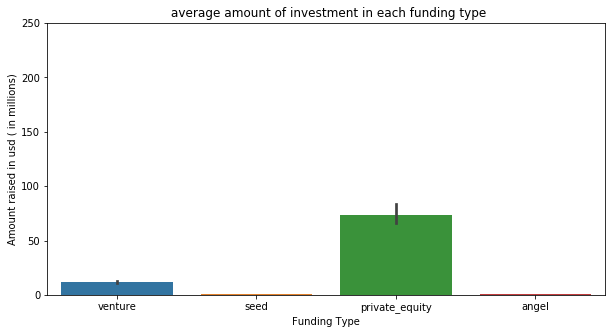

In [112]:
# A plot showing the average amount of investment in each funding type
plt.figure(figsize=(10,5))
plot=sns.barplot(x='funding_round_type',y='raised_amount_usd', data=master_frame)
plot.set(xlabel="Funding Type",ylabel="Amount raised in usd ( in millions)",title=" average amount of investment in each funding type")
plt.ylim(0, 250,10)
plt.show()

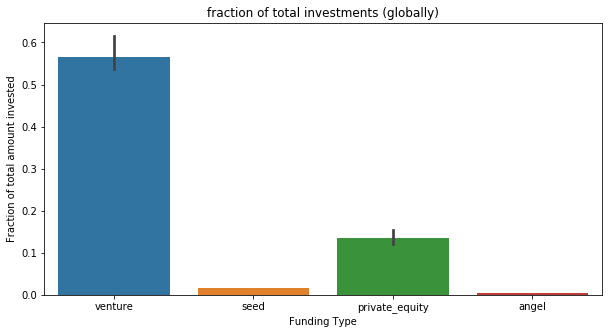

In [ ]:
# A plot showing the fraction of total investments (globally) in angel, venture, seed, and private equity
plt.figure(figsize=(10,5))
plot=sns.barplot(x='funding_round_type',y='Fraction_of_investment', data=master_frame,estimator=np.sum)
plot.set(xlabel="Funding Type",ylabel="Fraction of total amount invested",title="fraction of total investments (globally)")
plt.show()

In [ ]:
# A plot showing the top 9 countries against the total amount of investments of funding type Venture
plt.figure(figsize=(10,5))
plot=sns.barplot(x='country_code',y='raised_amount_usd',data=top9,estimator=np.sum)
plt.ylim(100,600000)
plot.set(ylabel="Amount raised ( in millions )")
plt.show()

In [ ]:
# A plot showing the number of investments in the top 3 sectors of the top 3 countries on one chart
top3=D1[D1['main_sector'].isin(["Others","Social, Finance, Analytics, Advertising","Cleantech / Semiconductors"])]
top3=top3.append(D2[D2['main_sector'].isin(["Others","Social, Finance, Analytics, Advertising","Cleantech / Semiconductors"])])
top3=top3.append(D3[D3['main_sector'].isin(["Others","Social, Finance, Analytics, Advertising","News, Search and Messaging"])])

In [ ]:
# A plot showing the number of investments in the top 3 sectors of the top 3 countries on one chart
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

plot=sns.barplot(x='country_code',y='raised_amount_usd',hue="main_sector",data=top3,estimator=lambda x: len(x))
plot.set(ylabel='raised_amount_usd ( in millions )')
plt.show()